# STA 208: Homework 1- part 2 

Fanling Liu, 920606416

# HW1 Wine Data Analysis (75pt)

## Instructions

You will be graded based on several criteria, and each is on a 5 point scale (5 is excellent - A - 1 is poor - C - 0 is not answered - D/F).  You should strive to 'impress us' if you want a 5.  This means excellent code, well explained conclusions, well annotated plots, correct answers, etc.

We will be grading you on several criteria:

- Conclusions: Conclusions should be consistent with the evidence provided, the conclusion should be well justified, the principles of machine learning that you have learned should be respected (such as overfitting and underfitting etc.)
- Correctness of calculations: code should be correct and reflect the principles learned in this course, the logic should be sound, the methods should match the setting and context, you should try many applicable methods that you have learned as long as they apply. 
- Code, Figures, and Text: Code should be annotated and easy to follow, with docstrings on the functions; captions, titles,  for figures 

__Exercise 2__ You should run the following code cells to import the code and reduce the variable set.  Address the questions after the code.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn import model_selection, linear_model, neighbors, preprocessing, metrics
from scipy import stats
%matplotlib inline
plt.style.use('ggplot')

# dataset path
data_dir = "../../data/"

In [2]:
# When running Jupter notebook on your local machine, use this to import data

datapath = "../../data/"
filename = datapath + 'winequality-red.csv'
sample_data = pd.read_csv(filename,delimiter=';')

In [3]:
sample_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
sample_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


The response variable is quality, and we choose columns 1-4 (volatile acidity - chlorides) as predictors. 

In [5]:
X = sample_data.iloc[:,range(1,5)]
y = sample_data.iloc[:,-1]

Check whether standardizing the data is necessary. If yes, standardize. If no, continue with unstandardized data.

In [7]:
# Standardize the data
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
X

array([[ 0.96187667, -1.39147228, -0.45321841, -0.24370669],
       [ 1.96744245, -1.39147228,  0.04341614,  0.2238752 ],
       [ 1.29706527, -1.18607043, -0.16942723,  0.09635286],
       ...,
       [-0.09955388, -0.72391627, -0.16942723, -0.24370669],
       [ 0.65462046, -0.77526673, -0.38227061, -0.26496041],
       [-1.21684919,  1.02199944,  0.75289408, -0.43499018]])

Explanation: Here, we standardlize X since the different chemical properties were measured in different units and scales.

In [8]:
X = np.array(X)
y = np.array(y)

In [9]:
def loo_risk(X,y,regmod):
    """
    Construct the leave-one-out square error risk for a regression model
    
    Input: design matrix, X, response vector, y, a regression model, regmod
    Output: scalar LOO risk
    """
    loo = LeaveOneOut()
    loo_losses = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regmod.fit(X_train,y_train)
        y_hat = regmod.predict(X_test)
        loss = np.sum((y_hat - y_test)**2)
        loo_losses.append(loss)
    return np.mean(loo_losses)

def emp_risk(X,y,regmod):
    """
    Return the empirical risk for square error loss
    
    Input: design matrix, X, response vector, y, a regression model, regmod
    Output: scalar empirical risk
    """
    regmod.fit(X,y)
    y_hat = regmod.predict(X)
    return np.mean((y_hat - y)**2)

__Exercise 2.1__ (25 pts) Compare the leave-one-out risk with the empirical risk for linear regression, on this dataset.

In [10]:
lr_loo_risk = loo_risk(X,y,linear_model.LinearRegression())
lr_emp_risk = emp_risk(X,y,linear_model.LinearRegression())
print("Leave-One-Out Risk of Linear Regression: ", lr_loo_risk)
print("Empirical Risk of Linear Regression: ", lr_emp_risk)

Leave-One-Out Risk of Linear Regression:  0.54737034750936
Empirical Risk of Linear Regression:  0.5437253694638106


__Conclusion__ The close alignment between the leave-one-out risk and empirical risk in the linear regression model suggests that the model performs well not only on the training data but also on the test data. This consistency across different subsets of the data indicates that the model is robust and likely to yield reliable predictions in various scenarios.

__Exercise 2.2__ (25 pts) Perform kNN regression for k = 1,3,5,...,49, and compare the leave-one-out risk with the empirical risk (on the training data). Plot the risks as a function of k. Remark on the tradeoff between bias and variance for this dataset and compare against linear regression.

Note: For implementing and testing your algorithm, use a small range of k's...

In [19]:
# one example of k = 5 nearest neighbors regression
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
knn_loo_risk = loo_risk(X,y,knn)
knn_emp_risk = emp_risk(X,y,knn)
print("Leave-One-Out Risk of KNN: ", knn_loo_risk)
print("Empirical Risk of KNN: ", knn_emp_risk)

Leave-One-Out Risk of KNN:  0.5602251407129456
Empirical Risk of KNN:  0.36885553470919324


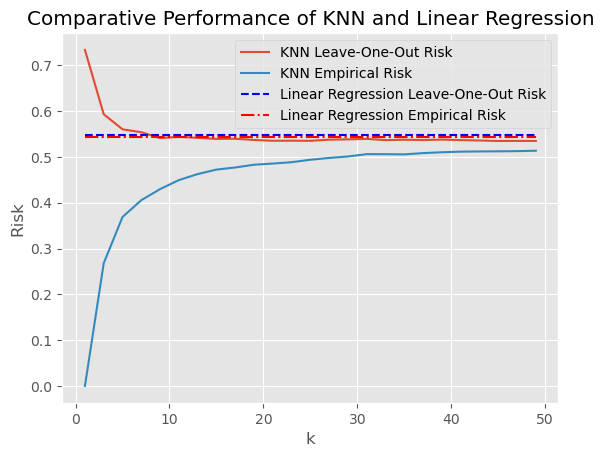

In [28]:
# compare the performance of linear regression and KNN
loo_risks = []
emp_risks = []
loo_risks_lr = []
emp_risks_lr = []
k_values = [k for k in range(1, 50, 2)]
for k in k_values:
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    loo_risks.append(loo_risk(X,y,knn))
    emp_risks.append(emp_risk(X,y,knn))
    lr = linear_model.LinearRegression()
    loo_risks_lr.append(loo_risk(X,y,lr))
    emp_risks_lr.append(emp_risk(X,y,lr))
plt.plot(k_values,loo_risks,label='KNN Leave-One-Out Risk')
plt.plot(k_values,emp_risks,label='KNN Empirical Risk')
plt.plot(k_values, loo_risks_lr, label='Linear Regression Leave-One-Out Risk', color='blue', linestyle='--')
plt.plot(k_values, emp_risks_lr, label='Linear Regression Empirical Risk', color='red', linestyle='-.')
plt.title('Comparative Performance of KNN and Linear Regression')
plt.xlabel('k')
plt.ylabel('Risk')
plt.legend()
plt.show()

__Conclusion__ The graph illustrate that the leave-one-out risk for kNN decreases notably as the value of k grows from 1 to 10, after which the decline in risk becomes more gradual. Conversely, the empirical risk for kNN shows an increase as k grows. This pattern demonstrates the bias-variance trade-off: a higher k results in increased bias but reduced variance. The linear regression model, meanwhile, exhibits equivalent levels of leave-one-out risk and empirical risk, suggesting a well-balanced trade-off between bias and variance. This balance indicates that the linear regression model is likely more stable in terms of data variance than the kNN model with a low k.

Linear regression offers consistent generalizability, as demonstrated by the similar values of leave-one-out and empirical risks. In contrast, kNN's performance is highly sensitive to the choice of k. The kNN model has the potential to achieve lower risks with an optimally chosen k, compared to the linear model, but this necessitates a careful trade-off of bias and variance.

__Exercise 2.3__ (25 pts) Implement forward stepwise regression (ESL section 3.3.2) for the linear model and compare the LOO risk for each stage.  Recall that at each step forward stepwise regression will select a new variable that most improves the empirical risk and include that in the model (starting with the intercept).

In [21]:
# Implement forward stepwise regression
def forward_stepwise(X,y):
    """
    Implement forward stepwise regression
    
    Input: design matrix, X, response vector, y
    Output: list of selected features
    """
    n_features = X.shape[1]
    selected_features = []
    for i in range(n_features):
        min_loss = np.inf
        for j in range(n_features):
            if j in selected_features:
                continue
            regmod = linear_model.LinearRegression()
            features = selected_features + [j]
            X_sub = X[:,features]
            loss = loo_risk(X_sub,y,regmod)
            if loss < min_loss:
                min_loss = loss
                best_feature = j
        selected_features.append(best_feature)
    return selected_features

Selected features:  [0, 3, 1, 2]
LOO risk for step 1 feature:  0.5538157575058303
LOO risk for step 2 feature:  0.5471450354542465
LOO risk for step 3 feature:  0.5466371713180824
LOO risk for step 4 feature:  0.5473703475093601


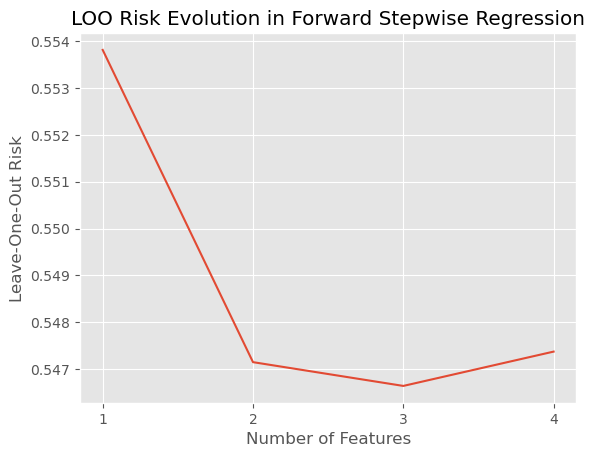

In [29]:
# check the selected features
selected_features = forward_stepwise(X,y)
print("Selected features: ", selected_features)
# Compare the LOO risk for each stage of forward stepwise regression
loo_risks = []
for i in range(1, X.shape[1]+1):
    regmod = linear_model.LinearRegression()
    X_sub = X[:,selected_features[:i]]
    loo_risks.append(loo_risk(X_sub,y,regmod))
    print("LOO risk for step", i, "feature: ", loo_risks[-1])
plt.plot(range(1, X.shape[1]+1),loo_risks)
plt.xlabel('Number of Features')
plt.ylabel('Leave-One-Out Risk')
plt.title('LOO Risk Evolution in Forward Stepwise Regression')
plt.xticks(range(1, X.shape[1] + 1))
plt.show()

__Conclusion__ Starting with a single feature in the model, the LOO risk is at its maximum, serving as a reference point for subsequent additions. The incorporation of a second feature results in a pronounced reduction in LOO risk, signaling a considerable improvement in predictive power. The addition of a third feature further reduces the LOO risk, indicating that this feature also contributes positively to the model's accuracy.

Contrarily, the introduction of a fourth feature slightly elevates the LOO risk above that of the model with two features. This increase may suggest that the fourth feature introduces either irrelevance or redundancy, possibly detracting from the model's predictive quality or reflecting overfitting to the training data. Therefore, this model with three features emerges as the optimal choice, offering the most enhanced performance according to the forward stepwise regression analysis.